In [8]:
from dotenv import load_dotenv
import os
from openai import OpenAI
import pandas as pd
import json
import csv
import matplotlib.pyplot as plt
import sounddevice as sd
import scipy.io.wavfile
import whisper
import time
import ssl
import certifi

In [9]:
player_df = pd.read_csv('/Users/pranavturlapati/COMP-560-Deepseekers/Data/database_24_25.csv')
team_df = pd.read_csv('/Users/pranavturlapati/COMP-560-Deepseekers/Data/NBA_Team_Stats.csv')

In [14]:
print("PWD:", os.getcwd())
print("Files here:", os.listdir())

load_dotenv(dotenv_path="/Users/pranavturlapati/COMP-560-Deepseekers/.env")
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

PWD: /Users/pranavturlapati/COMP-560-Deepseekers/Python
Files here: ['results', 'Classification.ipynb', 'temp.wav', 'Scripts.ipynb']


In [15]:
class DataParser:

    prompt_template: str = """# Always assign "team" to the actual team the identified player belongs to (based on NBA knowledge),
# and assign "opponent" to the other team in the input, regardless of order in the input code. And give the full name of the player.


Schema={
 team, opponent (str|null),
 graph, player_graph (bool),
 players (list|null),
 player_stat, team_stat (str|null)
}
PlayerStats=[MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,Data]
TeamStats=[GP,PPG,oPPG,pDIFF,PACE,oEFF,dEFF,eDIFF,SoS,rSoS,SAR,CONS,A4F,W,L,WIN%,eWIN%,pWIN%,ACH,STRK]
Example:
"MIL_TOR\nKyle Kuzma hits a 3" → 
{"team":"MIL","opponent":"TOR","graph":true,"player_graph":true,
 "players":["Kyle Kuzma"],"player_stat":"3P%","team_stat":null}
Now parse:
"""

    def __init__(self, client: OpenAI):
        self.client = client

    def parse(self, snippet: str,
              model: str = "gpt-4o-mini",
              temperature: float = 0.0) -> dict:
        full_prompt = self.prompt_template + "\nInput:\n" + snippet + "\nOutput:"
        resp = self.client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a helpful parser."},
                {"role": "user", "content": full_prompt}
            ],
            temperature=temperature,
            max_tokens=200
        )
        # Parse and return the JSON object
        return resp.choices[0].message.content


**Example Data Parse**


In [16]:
parser = DataParser(client)

In [17]:
prompts = pd.read_csv("/Users/pranavturlapati/COMP-560-Deepseekers/Data/sports thing - Sheet1.csv")
prompts.head()

,bkn_nop,sac_cha,cle_det,den_chi,nyk_cha,lal_okc,lac_sas,den_hou,phi_was,gsw_pho,...,lac_gsw,min_uta,mem_gsw,tor_sas,nyk_bkn,okc_uta,cle_nyk,min_mem,bos_cha,det_mil
0,alvarado fires away and buries the three,hurry seth Hurry nobody stopped the ball oh th...,this is rush it up Malik be a step up two won'...,Bulls beat the Nuggets earlier in the season a...,was oh my goodness going to give him some vert...,set to go here at center court And away we go ...,great to see coach Van Dundy back as the ball ...,rockets win They finished with 53 on the year ...,Champenny Alex Sar got that party started last...,They are great positional rebounders.,...,Bearden hits a three to start.,Utah opens the game with a three.,Moody starts for Golden State.,The tip is won by San Antonio and we're underway.,Claxton scores on the follow for Brooklyn.,"Wiggins drops the corner pass, turnover.","Nice feed inside, and Anunoby finishes near th...","Memphis wins the opening tip, and we're underway.",Payton Pritchard opens the game with the first...,Payton Pritchard starts strong with early buck...
1,immediately after that miss not too often that...,damonte Sabonis has led the NBA in rebounding ...,Mobley on the perimeter flips to Donovan Mitch...,Murray's going to be guarded by giddy he's got...,hornets going to take on Thunder tomorrow in OKC,we have an incredible color scheme tonight uni...,it'll be Clipper ball this has truly felt like...,The East has played and now it's time for the ...,AJ Johnson back into the lineup,For Ginsky there with the force but able to fi...,...,Chris hits from deep.,McDaniels drives to the rim and lays it in.,Jackson hits an early three.,"Castle loses the handle, Mo up to Barnes who d...",Awuah picks up a turnover and throws down a bi...,Lowry hits a smooth 10-footer.,Anunoby hits a three over Mobley.,Ja Morant opens the scoring with a jumper.,Pritchard scores again early—getting unleashed...,Kyle Kuzma hits a heat-check three—feeling it ...
2,have you never experienced it yourself i I hav...,look at that fancy right-handed finger roll mi...,jayen Z scream for Dennis Sher all the way ins...,okay in the lane the shot is good Jordan who h...,first bucket for the Knicks carl Anthony Towns,We got the Lakers with their gold unis,zoo gets the first touch for the Clippers goin...,Their winningest coach in franchise history an...,Ronnie Walker,They read and react as well as anybody in the ...,...,Jeff hits a jumper to get in rhythm.,McDaniels swats the shot on defense.,"Pajski drives, kicks to the wing, Rams hits hi...",Mobley hits a three from the top.,Payne hits from the outside.,"Turnover Utah, Isaiah Joe leads the break, fin...",Anunoby dishes beautifully to Robinson for a d...,Edwards runs the floor and throws it down.,Luke Kornet plays aggressively inside.,Connaughton drills a three for Milwaukee.
3,olen had it slapped away by Williams perfectly...,simpson takes his time and scores his first two,M with a high screen for Darius Garland gets i...,Murray is inside I was going to say a career h...,if you set the pace move around they can't use...,starts off things with a scoring of the two,he's made his last 12 tonight is Zoo's 77th ga...,Shen scores the first two points,Quinton Grimes comes up with the rebound,"Devin Booker, a flurry of moves, able to lay i...",...,Kawhi nails a mid-range jumper.,"Conley drives left, finishes, and draws the foul.",Jackson responds with another three.,Champagnie scores inside for Toronto.,"Martin taps it back, Johnson drills a three.",Wide open three drops again for OKC.,"Anunoby fakes, finds Hart, who knocks down a t...",Randle scores over Edy in a tough matchup.,Pritchard hits another jumper in rhythm.,Smith responds with a catch-and-shoot triple.
4,alvarado buries the three jose Alvarado's seco...,nice little move in the paint there by Nerkage,easy down deep for a dunk to Jaylen Duran,vich over to Giddy buellis lets it go that's good,can you steal points like that good jeff with ...,Reeves had 

In [18]:
def write_new_data(matchup:str):
    JSON_data = []
    for prompt in prompts[matchup]:
        if pd.notna(prompt):
            JSON_data.append(parser.parse(f"{matchup}\n{prompt}"))

    # Path to existing file
    csv_path = "/Users/pranavturlapati/COMP-560-Deepseekers/Data/parsed_outputs.csv"

    # Load the existing data
    with open(csv_path, mode="r", newline="") as f:
        reader = list(csv.reader(f))

    # Insert new header
    reader[0].append(matchup)

    # Add new column data
    for i, row in enumerate(reader[1:]):
        row.append(json.dumps(JSON_data[i]))

    # Write back the updated data
    with open(csv_path, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(reader)


In [21]:
write_new_data("lac_sas")

In [9]:
player_df.head()

,Player,Tm,Opp,Res,MP,FG,FGA,FG%,3P,3PA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,Data
0,Jayson Tatum,BOS,NYK,W,30.30,14,18,0.778,8,11,...,4,4,10,1,1,1,1,37,38.1,2024-10-22
1,Anthony Davis,LAL,MIN,W,37.58,11,23,0.478,1,3,...,13,16,4,1,3,1,1,36,34.0,2024-10-22
2,Derrick White,BOS,NYK,W,26.63,8,13,0.615,6,10,...,3,3,4,1,0,0,1,24,22.4,2024-10-22
3,Jrue Holiday,BOS,NYK,W,30.52,7,9,0.778,4,6,...,2,4,4,1,0,0,2,18,19.5,2024-10-22
4,Miles McBride,NYK,BOS,L,25.85,8,10,0.800,4,5,...,0,0,2,0,0,1,1,22,17.8,2024-10-22


In [7]:
import json
import matplotlib.pyplot as plt
import pandas as pd

def algo(json_obj: str, player_db: pd.DataFrame, team_db: pd.DataFrame) -> None:
    temp = json.loads(json_obj)
    
    if temp["graph"] and temp["player_graph"]:
        for player in temp["players"]:
            if player in player_db["Player"].values:
                player_stats = player_db[player_db['Player'] == player]
                opponent = temp["opponent"]
                opponent_stats = player_db[player_db['Opp'] == opponent]

                stat = temp["player_stat"]

                if stat == 'FG%':
                    player_avg = player_stats['FG'].sum() / player_stats['FGA'].sum()
                    league_avg = player_db['FG'].sum() / player_db['FGA'].sum()
                    opp_allowed_avg = opponent_stats['FG'].sum() / opponent_stats['FGA'].sum()

                elif stat == '3P%':
                    player_avg = player_stats['3P'].sum() / player_stats['3PA'].sum()
                    league_avg = player_db['3P'].sum() / player_db['3PA'].sum()
                    opp_allowed_avg = opponent_stats['3P'].sum() / opponent_stats['3PA'].sum()

                else:
                    player_avg = player_stats[stat].mean()
                    league_avg = player_db[stat].mean()
                    opp_allowed_avg = opponent_stats[stat].mean()

                labels = ['Player', 'League', 'Opp Allowed']
                values = [player_avg, league_avg, opp_allowed_avg]

                plt.figure(figsize=(6, 4))
                plt.bar(labels, values)
                plt.xlabel('Average')
                plt.ylabel(stat)
                plt.title(f'{player} — {stat}')
                plt.ylim(0, max(values) * 1.1)
                plt.grid(axis='y', linestyle='--', alpha=1.0)
                plt.tight_layout()
                plt.show()


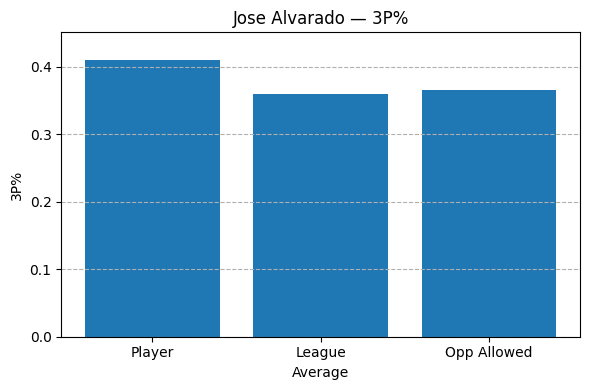

In [8]:
algo("{\"team\":\"BKN\",\"opponent\":\"NOP\",\"graph\":true,\"player_graph\":true,\"players\":[\"Jose Alvarado\"],\"player_stat\":\"3P%\",\"team_stat\":null}", player_df,team_df)

In [9]:
def record_audio(filename, duration=3, fs=44100):
    print("Recording...")
    audio = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='int16')
    sd.wait()
    scipy.io.wavfile.write(filename, fs, audio)
    print("Saved:", filename)

In [10]:
import whisper
model = whisper.load_model("base")

In [29]:
!pip uninstall -y whisper

Found existing installation: whisper 1.1.10
Uninstalling whisper-1.1.10:
  Successfully uninstalled whisper-1.1.10


In [7]:
!pip install git+https://github.com/openai/whisper.git

  Cloning https://github.com/openai/whisper.git to /private/var/folders/fm/jw3snghd1bl1t1l3p_r7gvth0000gn/T/pip-req-build-ng56hgx7
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /private/var/folders/fm/jw3snghd1bl1t1l3p_r7gvth0000gn/T/pip-req-build-ng56hgx7
  Resolved https://github.com/openai/whisper.git to commit 517a43ecd132a2089d85f4ebc044728a71d49f6e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached more_itertools-10.7.0-py3-none-any.whl.metadata (37 kB)
  Using cached numba-0.61.2-cp311-cp311-macosx_11_0_arm64.whl.metadata (2.8 kB)
  Using cached tiktoken-0.9.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.7 kB)
  Using cached llvmlite-0.44.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (4.8 kB)
Using cached more_itertools-10.7.0-py3-none-any.whl (65 kB)
Using cached numba-0.61.2-cp311-cp311-macosx_11_0_arm64.whl (2.8 MB)
Using cached llv

In [2]:
while True:
    record_audio("temp.wav", duration=5)
    result = model.transcribe("/Users/pranavturlapati/COMP-560-Deepseekers/Python/temp.wav")
    print("Transcript:", result["text"])
    result2 = parser.parse(f"gsw_lal\n{result["text"]}")
    algo(result2, player_df,team_df)
    time.sleep(0.5)
    

SyntaxError: f-string: unmatched '[' (1163683128.py, line 5)

In [ ]:
!